In [1]:
!date

Mon Jul 26 11:19:01 PDT 2021


# Subclass DE isoform hidden by gene [GLUT]

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/nmarkari/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
subclass_cmap = pd.read_csv('../../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [69]:
gene = anndata.read_h5ad("../../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../../data/notebook/revision/isoform.h5ad")

In [70]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [71]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [72]:
print(isoform.shape)
print(gene.shape)

(18175, 81527)
(18175, 26154)


In [73]:
# restrict to a class

In [74]:
gene= gene[np.logical_and(gene.obs.class_label=="Glutamatergic",np.logical_and(gene.obs.subclass_label!="L5 PPP",gene.obs.subclass_label!="CR"))]
isoform= isoform[np.logical_and(isoform.obs.class_label=="Glutamatergic",np.logical_and(isoform.obs.subclass_label!="L5 PPP",isoform.obs.subclass_label!="CR"))]

In [75]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.gene_name.values
assignments   = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
markers_gene = markers_gene.query("es > 0")

26-Jul-21 11:37:22 - 1 of 27 assignments: CA1-ProS
26-Jul-21 11:37:25 - 2 of 27 assignments: CA3
26-Jul-21 11:37:27 - 3 of 27 assignments: CT SUB
26-Jul-21 11:37:29 - 4 of 27 assignments: Car3
26-Jul-21 11:37:31 - 5 of 27 assignments: DG
26-Jul-21 11:37:33 - 6 of 27 assignments: IG-FC
26-Jul-21 11:37:36 - 7 of 27 assignments: L2  IT ENTl
26-Jul-21 11:37:39 - 8 of 27 assignments: L2 IT ENTm
26-Jul-21 11:37:41 - 9 of 27 assignments: L2/3 IT CTX
26-Jul-21 11:37:44 - 10 of 27 assignments: L2/3 IT ENTl
26-Jul-21 11:37:47 - 11 of 27 assignments: L2/3 IT PPP
26-Jul-21 11:37:48 - 12 of 27 assignments: L2/3 IT RHP
26-Jul-21 11:37:52 - 13 of 27 assignments: L3 IT ENT
26-Jul-21 11:37:54 - 14 of 27 assignments: L4 RSP-ACA
26-Jul-21 11:37:57 - 15 of 27 assignments: L4/5 IT CTX
26-Jul-21 11:38:00 - 16 of 27 assignments: L5 IT CTX
26-Jul-21 11:38:02 - 17 of 27 assignments: L5 IT TPE-ENT
26-Jul-21 11:38:04 - 18 of 27 assignments: L5 NP CTX
26-Jul-21 11:38:07 - 19 of 27 assignments: L5 PT CTX
26-Jul-21

CPU times: user 41.8 s, sys: 34.7 s, total: 1min 16s
Wall time: 1min 16s


In [76]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
markers_isoform = markers_isoform.query("es > 0")

26-Jul-21 11:38:43 - 1 of 27 assignments: CA1-ProS
26-Jul-21 11:38:48 - 2 of 27 assignments: CA3
26-Jul-21 11:38:55 - 3 of 27 assignments: CT SUB
26-Jul-21 11:39:00 - 4 of 27 assignments: Car3
26-Jul-21 11:39:05 - 5 of 27 assignments: DG
26-Jul-21 11:39:10 - 6 of 27 assignments: IG-FC
26-Jul-21 11:39:17 - 7 of 27 assignments: L2  IT ENTl
26-Jul-21 11:39:22 - 8 of 27 assignments: L2 IT ENTm
26-Jul-21 11:39:28 - 9 of 27 assignments: L2/3 IT CTX
26-Jul-21 11:39:34 - 10 of 27 assignments: L2/3 IT ENTl
26-Jul-21 11:39:40 - 11 of 27 assignments: L2/3 IT PPP
26-Jul-21 11:39:45 - 12 of 27 assignments: L2/3 IT RHP
26-Jul-21 11:39:51 - 13 of 27 assignments: L3 IT ENT
26-Jul-21 11:39:56 - 14 of 27 assignments: L4 RSP-ACA
26-Jul-21 11:40:02 - 15 of 27 assignments: L4/5 IT CTX
26-Jul-21 11:40:08 - 16 of 27 assignments: L5 IT CTX
26-Jul-21 11:40:13 - 17 of 27 assignments: L5 IT TPE-ENT
26-Jul-21 11:40:19 - 18 of 27 assignments: L5 NP CTX
26-Jul-21 11:40:25 - 19 of 27 assignments: L5 PT CTX
26-Jul-21

CPU times: user 1min 9s, sys: 1min 35s, total: 2min 44s
Wall time: 2min 44s


# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not for each subclass

In [77]:
alpha =0.01
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [78]:
setdiff.shape

(24132,)

In [79]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es,index_name
278209,Car3,Aldoa-210_ENSMUST00000151137.8,2.13599e-168,7.32216e-165,3.02922,Car3_Aldoa
2109747,NP SUB,Myl6-206_ENSMUST00000218127.2,7.35943e-114,2.09523e-110,2.93286,NP SUB_Myl6
1131423,L4 RSP-ACA,Myl6-206_ENSMUST00000218127.2,3.12126e-21,1.33527e-17,2.12696,L4 RSP-ACA_Myl6
1329990,L5 IT TPE-ENT,Snap25-202_ENSMUST00000110098.4,0,2.22507e-308,2.02236,L5 IT TPE-ENT_Snap25
1080913,L4 RSP-ACA,Rps24-205_ENSMUST00000223999.2,2.15108e-19,9.20232e-16,1.97676,L4 RSP-ACA_Rps24
596247,L2 IT ENTm,Snap25-202_ENSMUST00000110098.4,5.53848e-38,2.31508e-34,1.92622,L2 IT ENTm_Snap25
469756,IG-FC,Kalrn-207_ENSMUST00000114960.9,5.44678e-07,0.00207631,1.83076,IG-FC_Kalrn
444923,IG-FC,Aph1b-201_ENSMUST00000034934.15,8.92184e-07,0.00340101,1.74269,IG-FC_Aph1b
410355,IG-FC,Farsa-201_ENSMUST00000003906.13,1.91947e-06,0.00731701,1.71241,IG-FC_Farsa
424126,IG-FC,Dgkg-202_ENSMUST00000089925.10,2.91653e-08,0.000111178,1.70175,IG-FC_Dgkg


In [80]:
specific_cluster = "Car3"
specific_isoform = "Aldoa-210_ENSMUST00000151137.8"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [81]:
specific_gene

'Aldoa'

In [82]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

['Aldoa_ENSMUSG00000030695.17', 'Aldoa_ENSMUSG00000114515.3']
Categories (26154, object): ['5S_rRNA_ENSMUSG00000118681.1', '5S_rRNA_ENSMUSG00000118725.1', '5S_rRNA_ENSMUSG00000118727.1', '5S_rRNA_ENSMUSG00000118747.1', ..., 'n-R5s25_ENSMUSG00000064857.3', 'n-R5s41_ENSMUSG00000064959.3', 'n-R5s173_ENSMUSG00000064554.3', 'n-R5s185_ENSMUSG00000065887.2']

In [83]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [84]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    ax.set_xticklabels(labels, rotation=45, ha="right")

    
    return ax


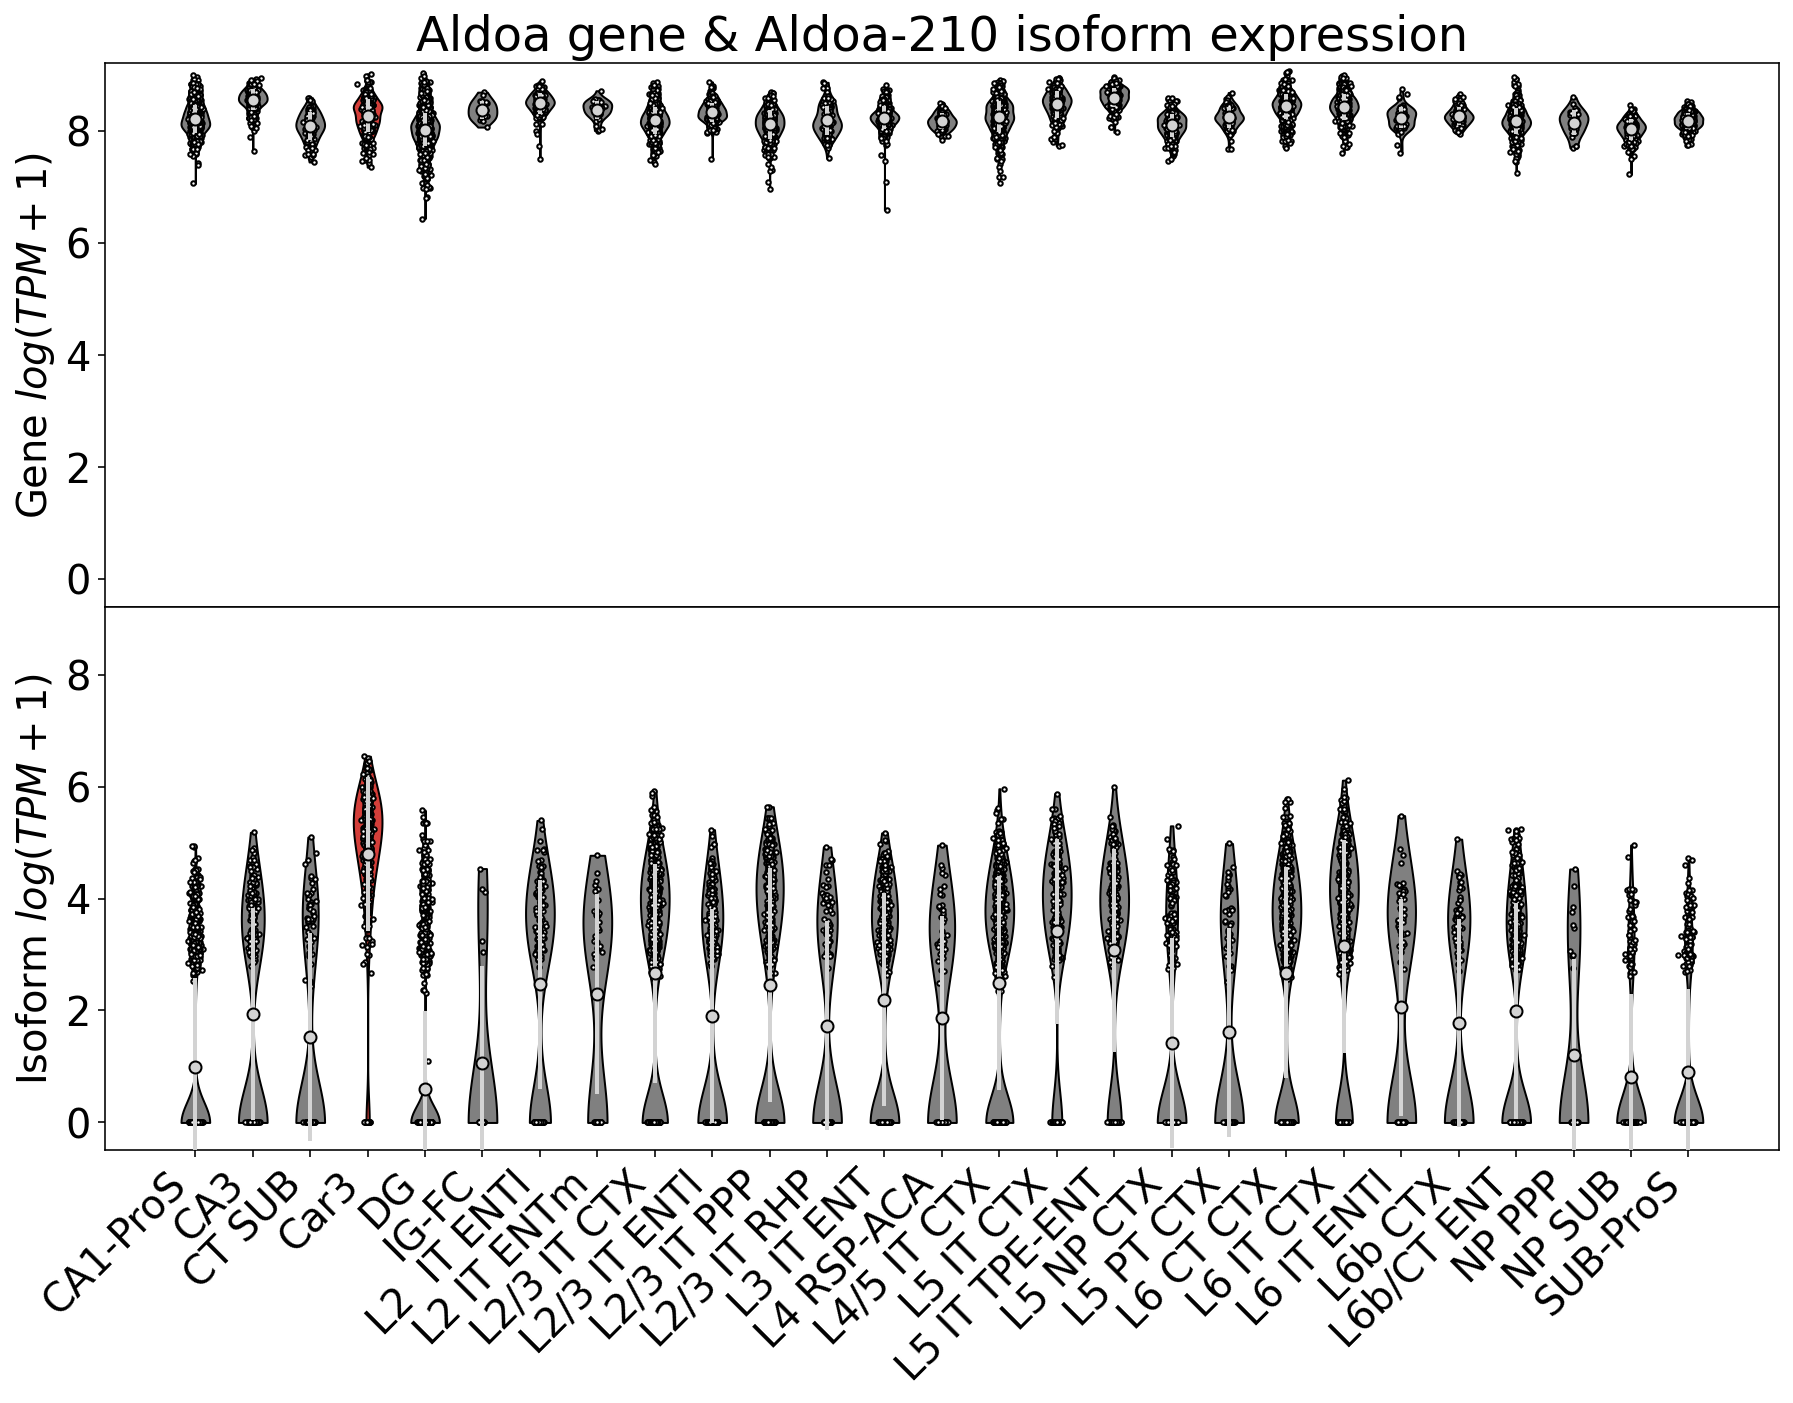

In [85]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)


######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.subclass_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)

ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",
    "ylim": -0.5

})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})

plt.savefig("../../../figures/subclass_DE_violin_{}-GLUT.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

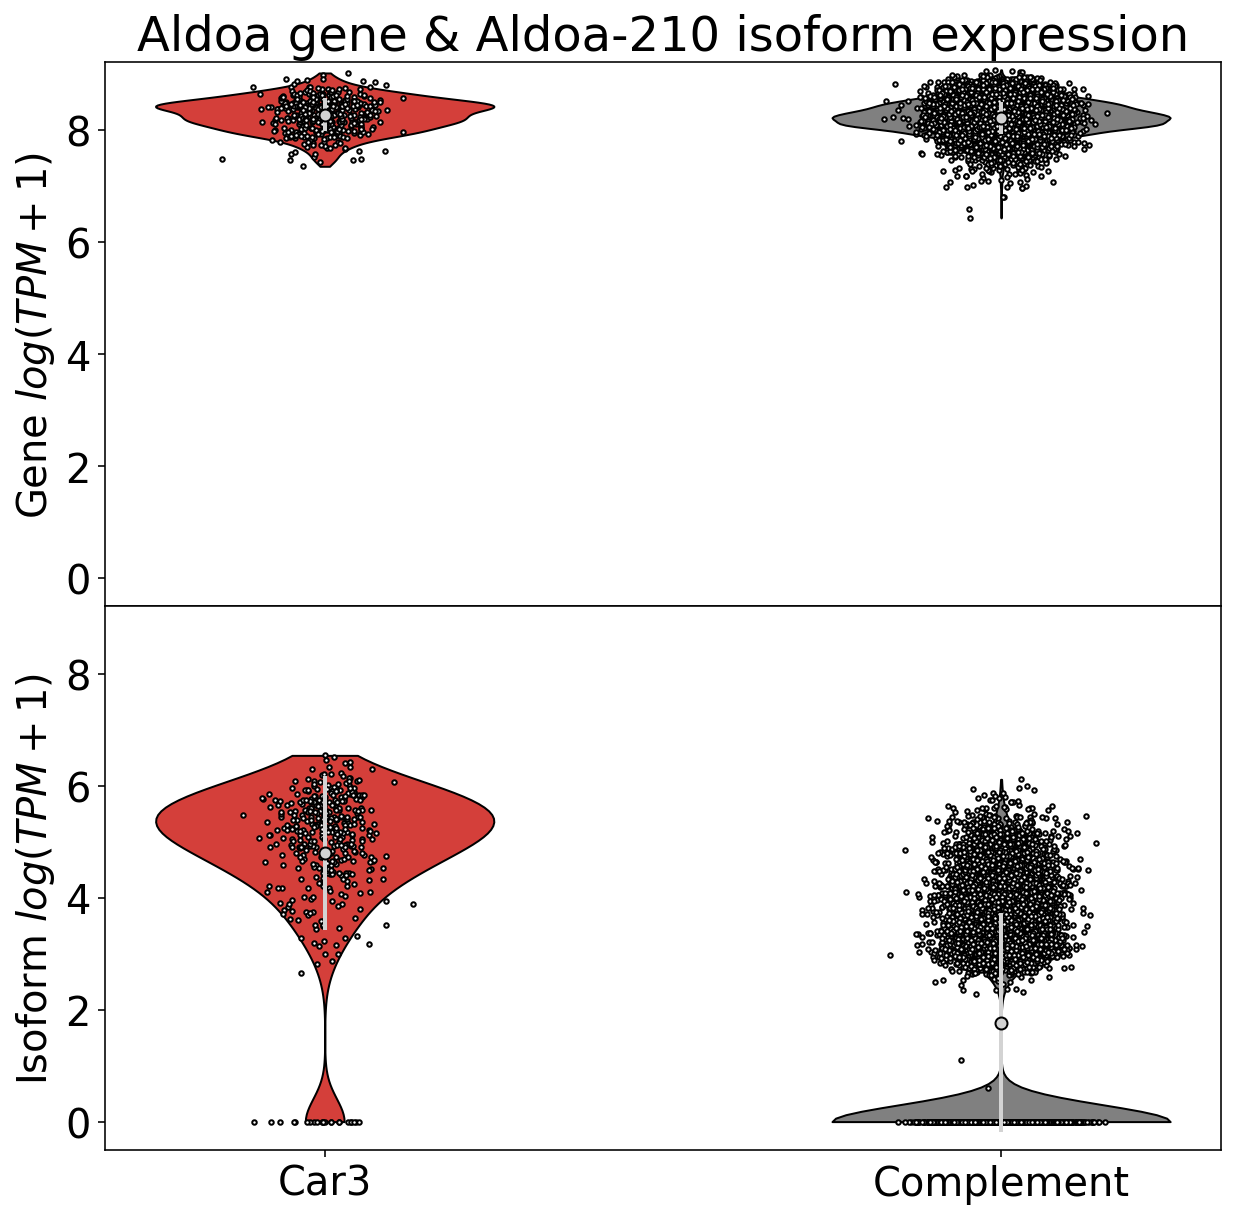

In [86]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
labels = [specific_cluster, "Complement"]
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

#######3# Gene
x = []
x.append(np.asarray(gene[gene.obs.subclass_label==specific_cluster][:,gene.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
x.append(np.asarray(gene[gene.obs.subclass_label!=specific_cluster][:,gene.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=0)

#################### BAD GENE ####################
x = []

x.append(np.asarray(isoform[isoform.obs.subclass_label==specific_cluster][:,isoform.var.transcript_name.values==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())
x.append(np.asarray(isoform[isoform.obs.subclass_label!=specific_cluster][:,isoform.var.transcript_name.values==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=0, xticks=lidx, xticklabels=labels)


ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",
    "ylim": -0.5

})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})

ax[1].set_xticklabels(labels, rotation=0, ha="center")


plt.show()

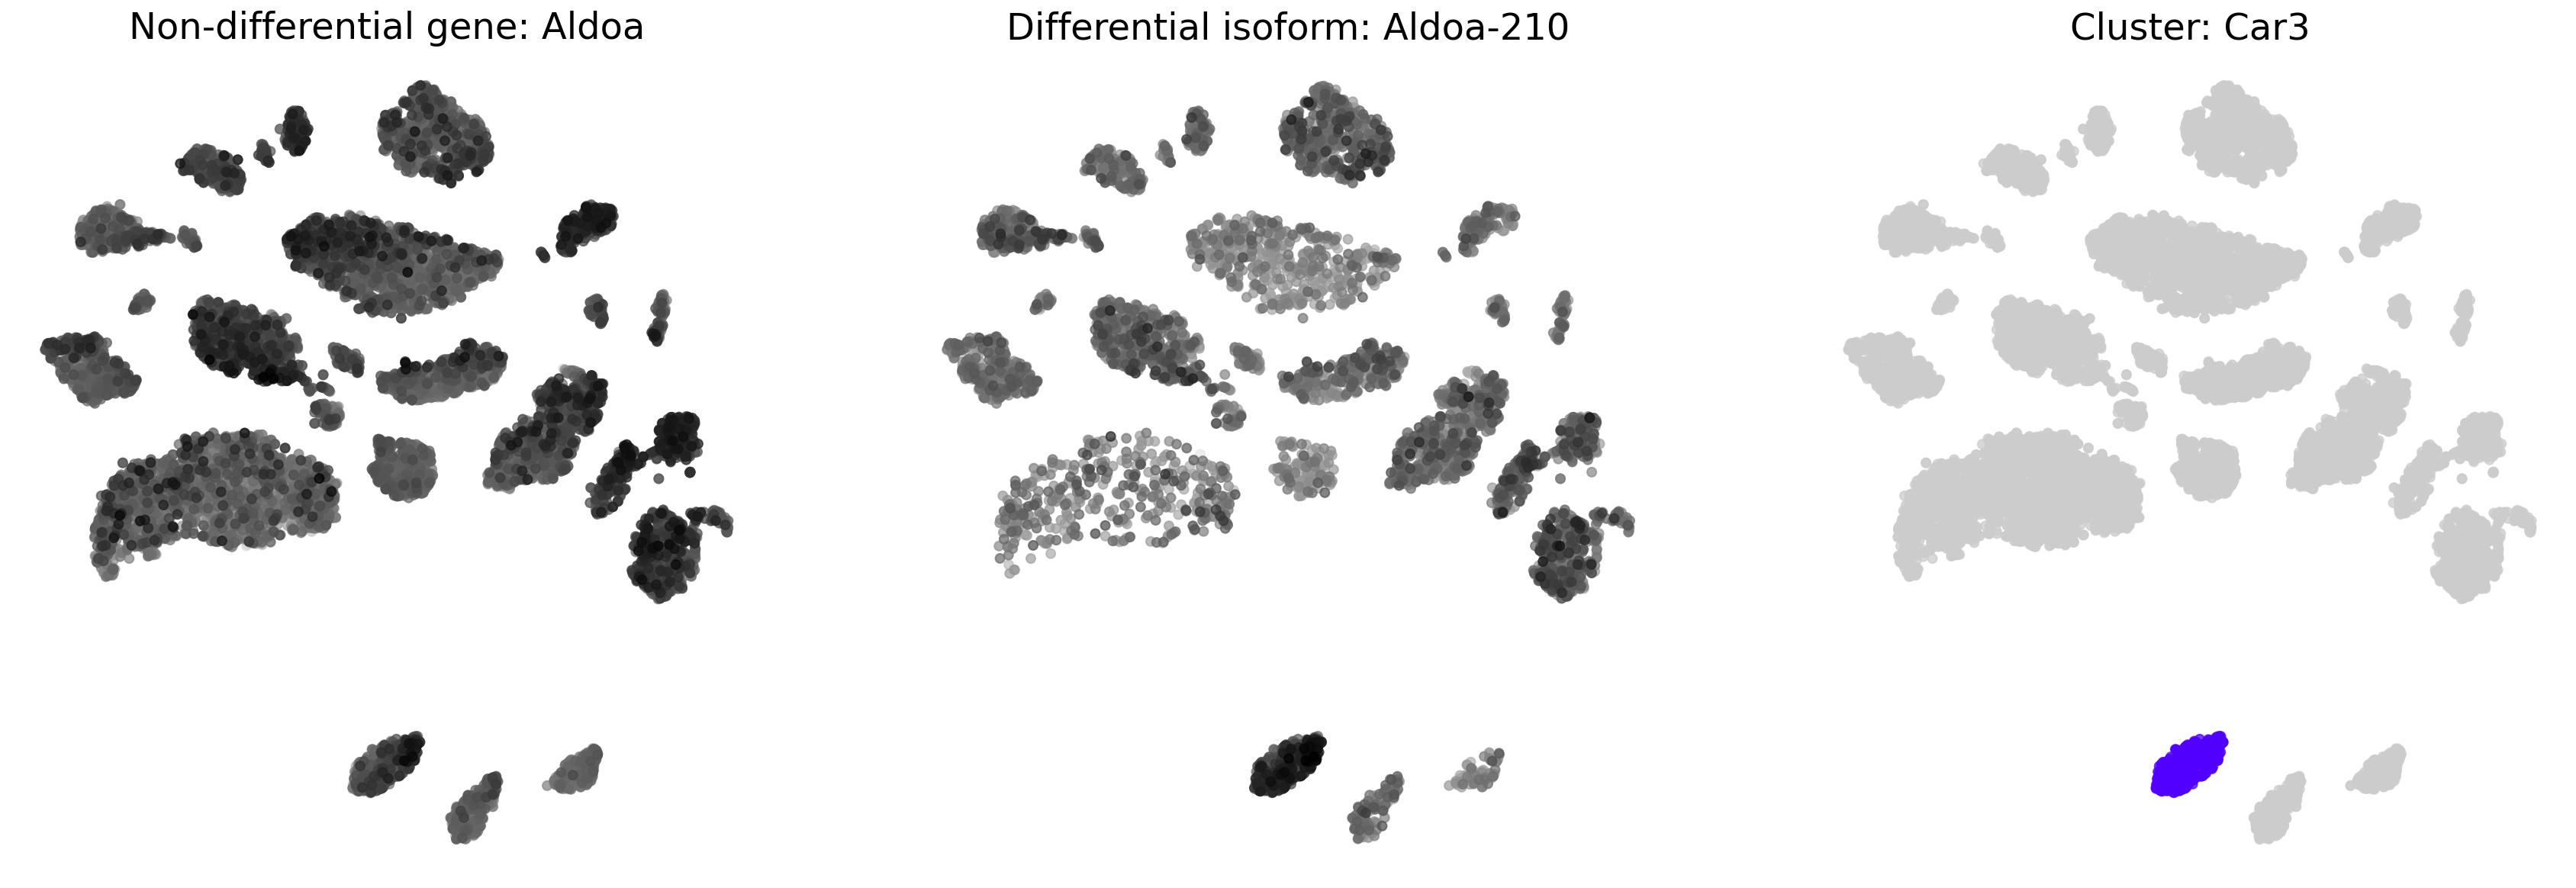

In [87]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(gene.obs["subclass_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
    
c = np.array(c)
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster.split("_")[0]))
plt.savefig("../../../figures/subclass_DE_nca_{}-GLUT.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [88]:
identified_isoforms = markers_isoform["name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [89]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0])

In [90]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

2712 isoforms from 1303 genes identified.


In [91]:
markers_isoform.to_csv("../../../tables/unordered/subclass_DE-GLUT.csv")

In [92]:
markers_isoform[markers_isoform.name.str.contains("Nrxn")]

,index,name,p_raw,p_corr,es,index_name
18114,CA1-ProS,Nrxn1-225_ENSMUST00000197268.5,5.01854e-24,1.91307e-20,0.184634,CA1-ProS_Nrxn1
1322551,L5 IT TPE-ENT,Nrxn1-207_ENSMUST00000160844.10,5.12708e-08,0.000239178,0.350995,L5 IT TPE-ENT_Nrxn1
18111,CA1-ProS,Nrxn1-215_ENSMUST00000173917.8,1.50489e-90,5.73664e-87,0.594704,CA1-ProS_Nrxn1
507281,L2 IT ENTl,Nrxn1-207_ENSMUST00000160844.10,4.41307e-17,1.95234e-13,0.685613,L2 IT ENTl_Nrxn1
2137821,SUB-ProS,Nrxn1-207_ENSMUST00000160844.10,1.17984e-63,5.35527e-60,0.721092,SUB-ProS_Nrxn1
181173,CT SUB,Nrxn1-207_ENSMUST00000160844.10,9.27025e-12,1.92728e-08,0.758716,CT SUB_Nrxn1
588808,L2 IT ENTm,Nrxn1-207_ENSMUST00000160844.10,1.36873e-06,0.00572129,0.818769,L2 IT ENTm_Nrxn1
2056294,NP SUB,Nrxn1-207_ENSMUST00000160844.10,2.38066e-75,6.77773e-72,1.40898,NP SUB_Nrxn1
1811713,L6b CTX,Nrxn1-207_ENSMUST00000160844.10,1.22421e-51,4.73769e-48,1.4572,L6b CTX_Nrxn1
1974767,NP PPP,Nrxn1-207_ENSMUST00000160844.10,6.30995e-10,1.63175e-06,1.4794,NP PPP_Nrxn1
